# T-brain: 台灣不動產預測

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('float_format', '{:f}'.format)

### 評分方式
* 國外關於自動估價系統（Automated Valuation Model, AVM）研究對模型準確度好壞之判定，多以命中率（Hit-Ratio或Hit-Rate）為標準。


* Hit-Rate 表示有多少比例個案之估值誤差低於某一誤差水準值（本次競賽為10%），Hit-Rate 愈高表示模型精確度愈高。


* Hit-Rate的計算共分為兩步驟，首先比對各筆不動產預測 $\hat{y}$ 和真實價格 $y$ 的誤差水準是否小於等於 10%，若是，則為 1；若否，則為 0。


* $Z_i = 1 \quad if \mid{\frac{\hat{y_i}-y_i}{y_i}\mid \leq 10\%} \quad else \quad 0$，
最終將各數值取平均，得到最終的 Hit-Rate: $\frac{\sum{Z_i}}{n}$


* 不過考量到Hit Rate可能出現同分的情形，因此本次比賽採用 Hit Rate 結合 MAPE 作為最終的評分方式: $MAPE = \frac{\sum\mid{\frac{\hat{y_i}-y_i}{y_i}\mid}}{n}$ then $ Score = round(Hit\_Rate, 4)*10^4 + (1-(1 \quad if \quad MAPE \geq 1 \quad else \quad MAPE))$

In [4]:
# Evaluation
def evaluate(y_hat, y_true):
    size = y_true.shape[0]
    results = abs((y_hat-y_true)/y_true)
    tor = [0 if v > 0.1 else 1 for v in results]
    hit_rate = sum(tor)/size
    MAPE = sum(results)/size
    MAPE = 1 if MAPE >= 1 else MAPE
    score = round(hit_rate, 4)*(10**4) + (1 - MAPE)
    return score

### test example ###
#df = pd.DataFrame({'y_hat':[1300, 1100, 1050], 'y_true':[1000, 1000, 1000]})
#evaluate(df['y_hat'], df['y_true'])

In [5]:
df_train = pd.read_csv('train.csv')
df_train.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,nan,...,58,1,157,1,2483,1,6011,1,34.469803,647603.770472
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,nan,...,28,1,115,1,15872,1,32221,1,40.073573,3321452.000000
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,nan,...,78,1,212,1,15760,1,32228,1,54.462081,9570885.316206
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,nan,...,20,1,125,1,2568,1,7271,1,99.628966,14215011.127100
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,nan,...,18,1,47,1,2587,1,7442,1,124.131236,762711.975714


In [6]:
df_train.columns # there is no 'total_price' column in test.csv

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

In [7]:
df_train['total_price'].describe()

count        60000.000000
mean      12937270.809873
std       55224630.345758
min         226149.523986
25%        2433113.847539
50%        5240482.134724
75%       11239323.003503
max     5088279096.769050
Name: total_price, dtype: float64

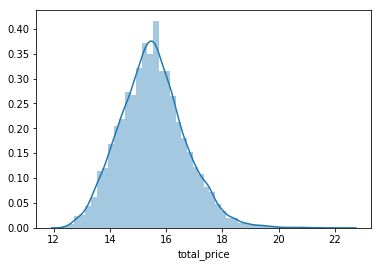

In [8]:
#histogram from log tranformation
sns.distplot(df_train['total_price'].apply(np.log)); 

In [9]:
#skewness and kurtosis
print("Skewness: %f" % df_train['total_price'].apply(np.log).skew())
print("Kurtosis: %f" % df_train['total_price'].apply(np.log).kurt())

Skewness: 0.375563
Kurtosis: 0.537999


偏度與峰度高的誇張，但不知道這樣的結果對後面預測的能力是否有很大的影響??
* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
* If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.
* If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.

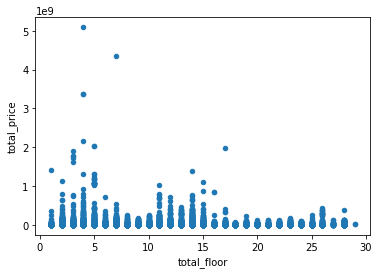

In [10]:
#scatter plot
var = 'total_floor'
data = pd.concat([df_train['total_price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='total_price');

總樓層越多，不一定總價越高，很多低樓層的建物，總價很高，可能跟地區有關!

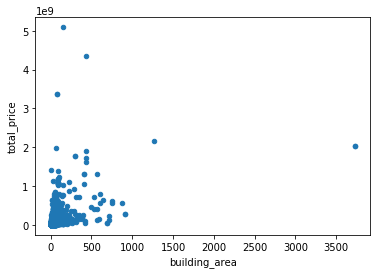

In [11]:
#scatter plot
var = 'building_area'
data = pd.concat([df_train['total_price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='total_price');

建物面積越大，不一定總價越高，有可能跟地區有關!?


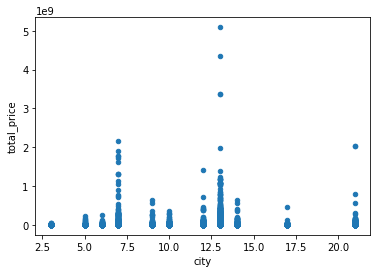

In [12]:
#scatter plot
var = 'city'
data = pd.concat([df_train['total_price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='total_price');

In [13]:
df_train['city'].value_counts()

7     19664
13    10756
21     7964
12     7264
14     4704
10     4676
5      1224
9      1125
17      984
6       826
3       813
Name: city, dtype: int64

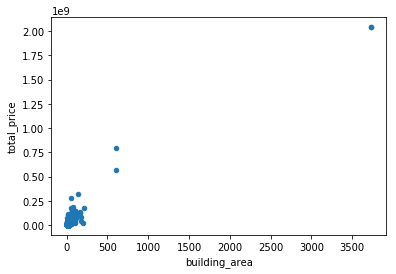

In [14]:
# fix one area plot the price of area
df = df_train[df_train['city'] == 21]
var = 'building_area'
data = pd.concat([df['total_price'], df[var]], axis=1)
data.plot.scatter(x=var, y='total_price');

In [15]:
df_train['txn_dt'].value_counts()
print('max of txn_df:', max(df_train['txn_dt']))
print('min of txn_df:', min(df_train['txn_dt']))
print('averge of txn_df:', np.mean(df_train['txn_dt']))

max of txn_df: 20665
min of txn_df: 18112
averge of txn_df: 19488.957916666666


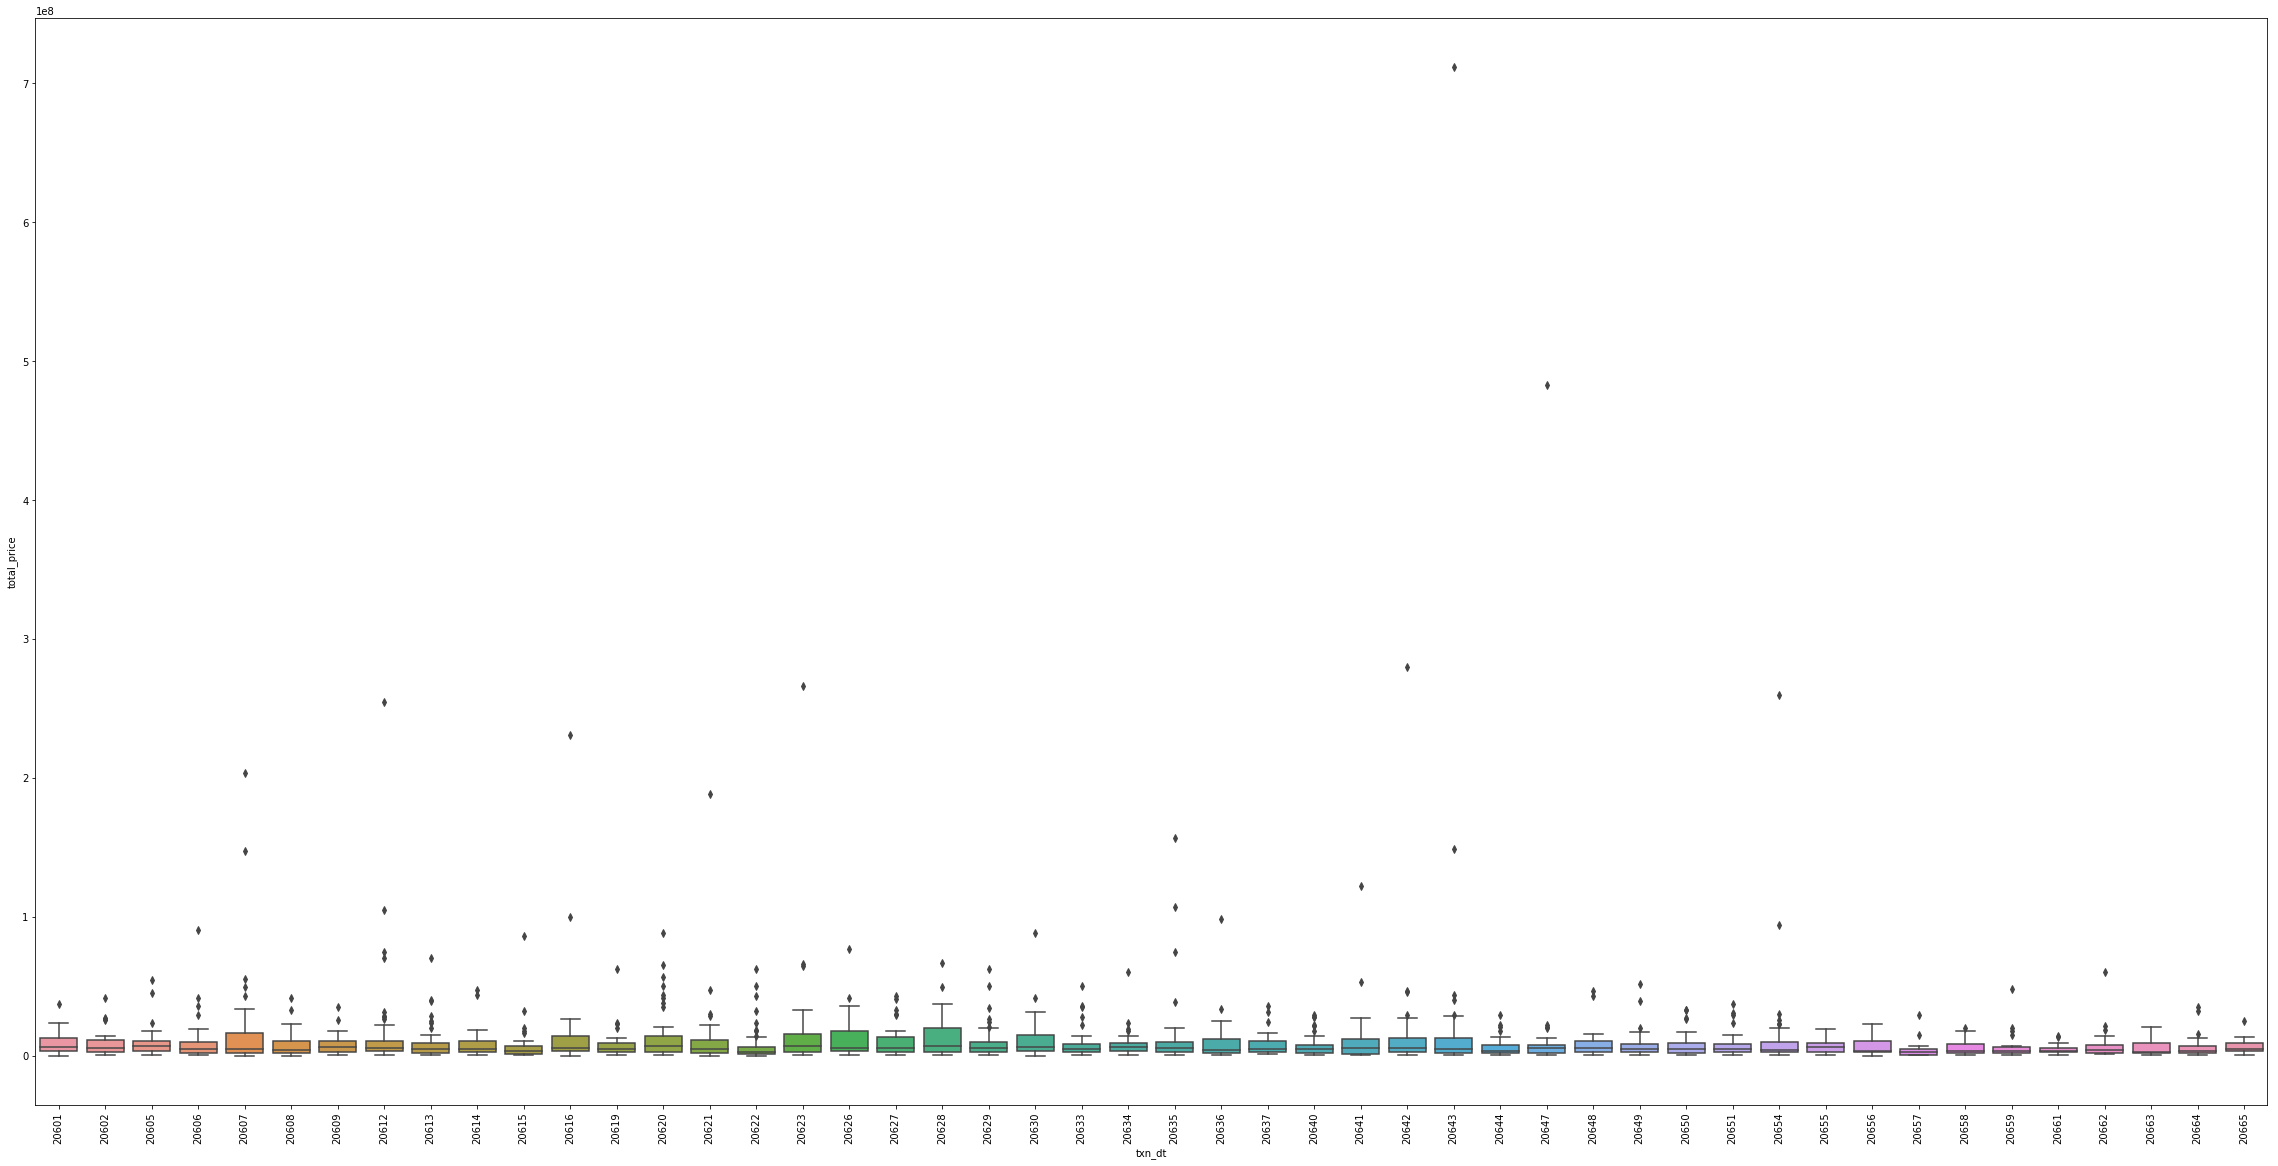

In [16]:
df = df_train[(df_train['txn_dt'] > 20600) & (df_train['txn_dt'] <= 20665)]
var = 'txn_dt'
data = pd.concat([df['total_price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(40, 20))
fig = sns.boxplot(x=var, y="total_price", data=data)
#fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor

# prepare data
df_train.dropna(axis=0, subset=['total_price'], inplace=True)
y = df_train['total_price']
X = df_train.drop(['total_price'], axis=1).select_dtypes(exclude=['object'])
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

# create a xgboost model
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)

# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

# make predictions
predictions = my_model.predict(test_X)

# Evaluation
print("Evaluation : " + str(evaluate(predictions, test_y)))

Evaluation : 2455.5593163762073


In [ ]:
y = df_train['total_price']
X = df_train.drop(['total_price'], axis=1).select_dtypes(exclude=['object'])
train_X = my_imputer.fit_transform(df_train_X)